# Univariate time series forecasting:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import keras
import tensorflow
import statsmodels.tsa as sm 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMAResults, ARIMA
from statsmodels.graphics import tsaplots
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import seaborn as sns
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Activation, Bidirectional, Flatten, TimeDistributed, SimpleRNN, Dropout, GRU, Input, Add, Multiply, Conv1D, MaxPooling1D
from tensorflow.keras import optimizers, initializers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import TruncatedNormal, Constant, RandomNormal
from tensorflow.keras.layers import LeakyReLU, ELU  # Updated import

import pickle
%matplotlib inline

In [2]:
import numpy as np
import tensorflow as tf

np.random.seed(2019)  # for initializing models with the same weights every time.
tf.random.set_seed(2019)  # Set the random seed for TensorFlow.

validation_split = 0.25  # for train-test split of dataset.


In [3]:
#metrics:
#root mean squared error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

#mean absolute percentage error
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    return mape

#symmetric mean absolute error
def SMAPE(y_true, y_pred):
    smape = 100/len(y_true) * np.sum(2 * np.abs(np.array(y_pred) - np.array(y_true)) / (np.abs(np.array(y_true)) + np.abs(np.array(y_pred))))
    return smape

#mean squared logarithmic error:
def MSLE(y_true, y_pred):
    rmse = mean_squared_log_error(y_true, y_pred)
    return rmse

ADF test results: (-3.1184724787047076, 0.025216003299528562, 0, 988, {'1%': -3.4369860032923145, '5%': -2.8644697838498376, '10%': -2.5683299626694422}, -3961.899432049059)
High p-value of ADF test (0.025216003299528562) shows that we fail to reject null hypothesis. 
 Hence, the dataset is non-stationary.


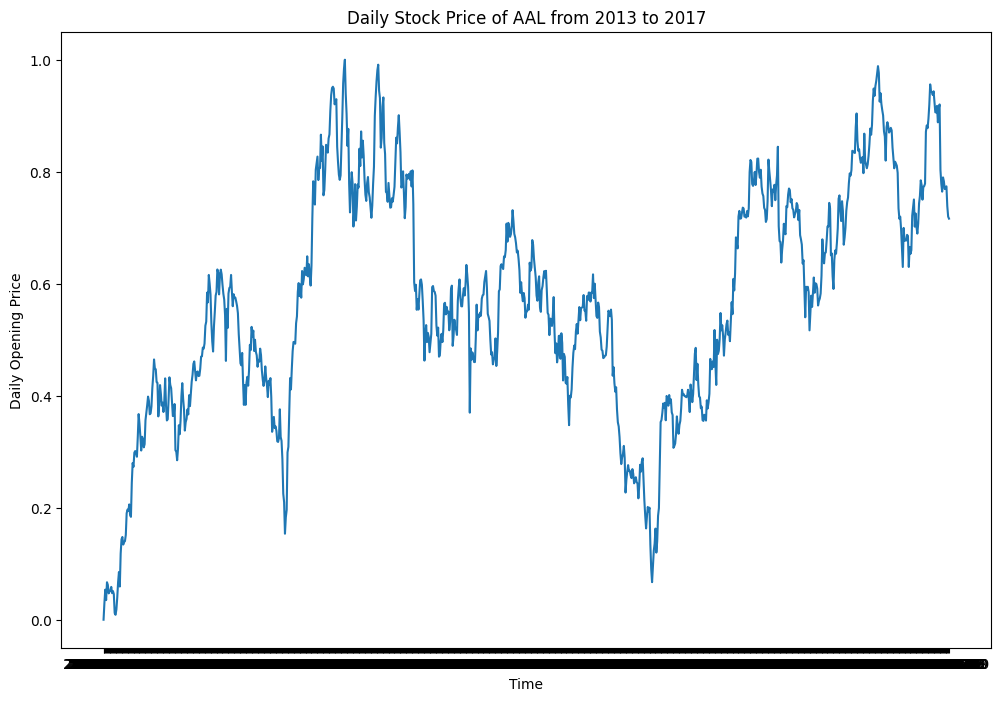

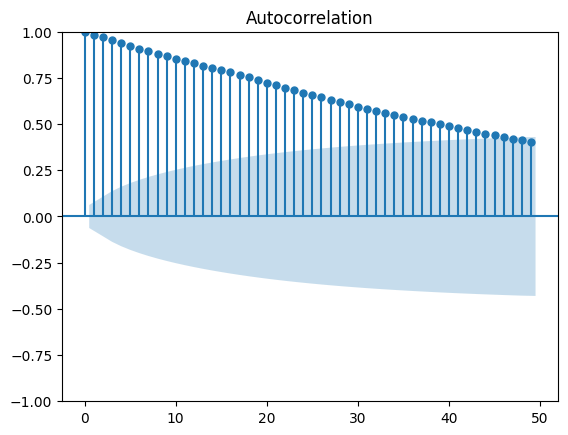

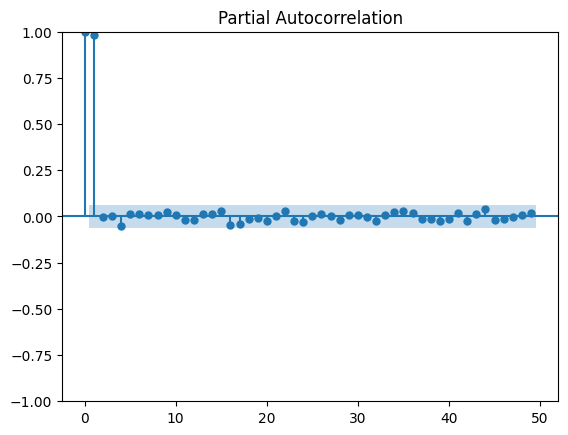

In [4]:
aal = pd.read_csv(r'C:\Users\KaanGermiyan\TimeSeries_Forecasting\Univariate-Time-Series-Forecasting-master\Data\Stocks\aal.us.txt', sep = ',')
aal.set_index('Date', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
df = pd.DataFrame({"Open":scaler.fit_transform(np.array(aal['Open']).reshape(len(aal),1)).reshape(len(aal),)},
                  index = aal.index)
plt.figure(figsize=(12,8))
plt.plot(df)
plt.xlabel('Time')
plt.ylabel('Daily Opening Price')
plt.title('Daily Stock Price of AAL from 2013 to 2017')
plt.savefig('fig1.png', dpi=800)  # Removed quality parameter
tsaplots.plot_acf(df, ax=None, lags=np.arange(50), use_vlines=True)
tsaplots.plot_pacf(df, ax=None, lags=np.arange(50), use_vlines=True)
print("ADF test results:", sm.stattools.adfuller(df.iloc[:,0], autolag='AIC'))
print('High p-value of ADF test ({}) shows that we fail to reject null hypothesis. \n Hence, the dataset is non-stationary.'.format(sm.stattools.adfuller(df.iloc[:,0], autolag='AIC')[1]))

C:\Users\KaanGermiyan\AppData\Local\Temp\ipykernel_23872\456149178.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


ADF test results: (-10.772702913719275, 2.1522184775714684e-19, 4, 974, {'1%': -2.568039305769304, '5%': -1.9412792832785186, '10%': -1.6165501434408924}, -3999.4435330200467)
Low p-value of ADF test (2.1522184775714684e-19) shows that we will reject the null hypothesis. 
Hence, the residual is close to stationary.
P-value of ADF test on the noise (with no constant, no trend) shows that data is stationary.
Hence, we can say that data is trend stationary.


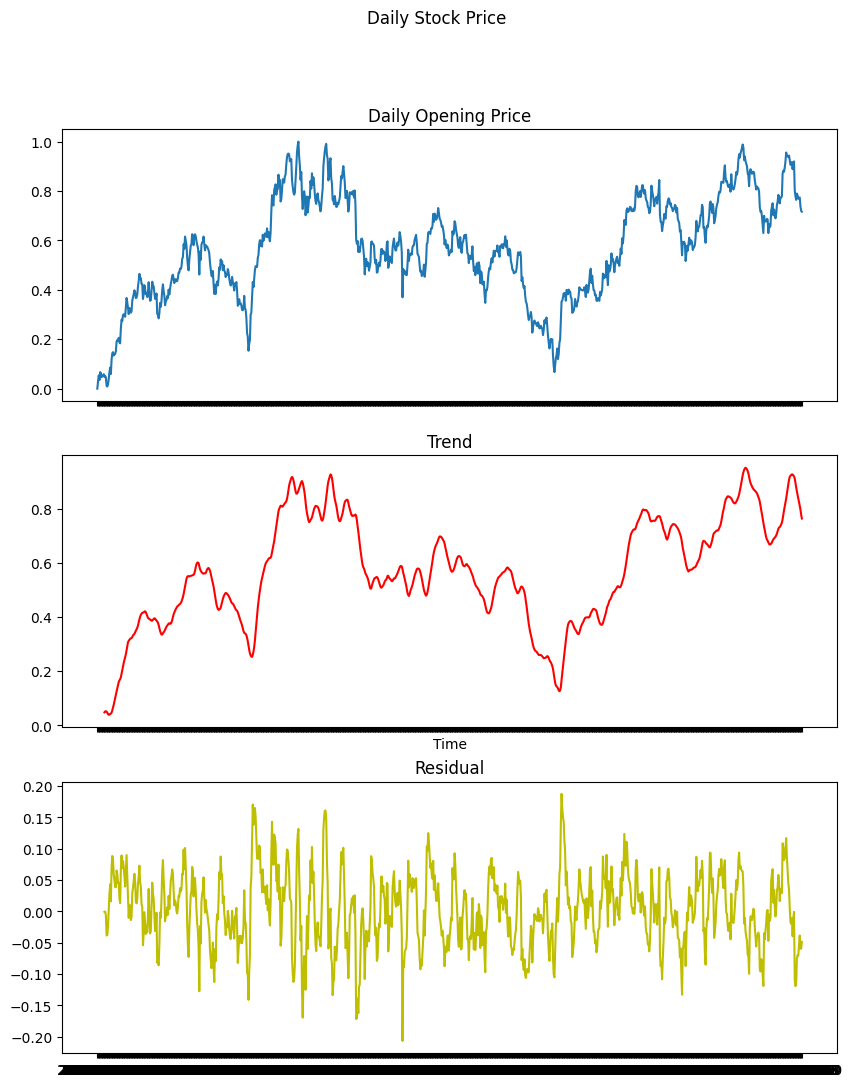

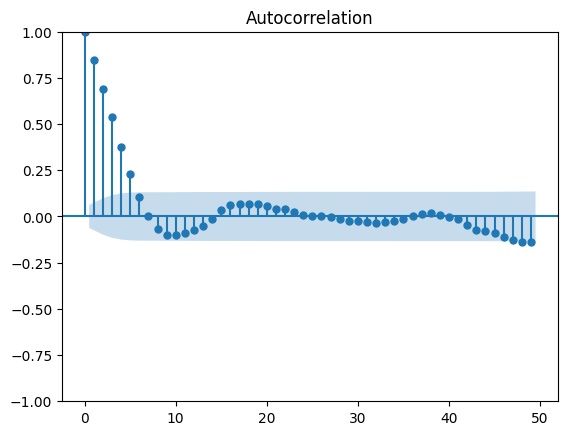

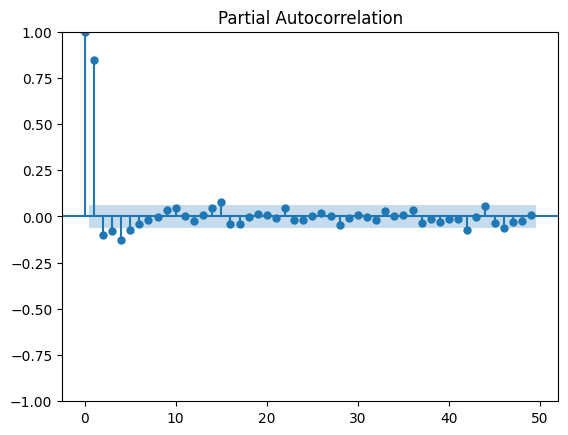

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller  # Doğru import
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots

# Trend bileşeni hesaplama
trendcomp = df.rolling(10).mean().rolling(2).mean()
res = df - trendcomp

# Gürültü hesaplama
noise = df.iloc[:, 0] - trendcomp.iloc[:, 0]
df['trendcomp'] = trendcomp.values
df['noise'] = noise.values

# Grafik oluşturma
fig = plt.figure(1, figsize=[10, 12])
fig.suptitle('Daily Stock Price')
fig1, fig2, fig4 = fig.subplots(nrows=3, ncols=1, sharex=True, sharey=False)
fig1.set_title('Daily Opening Price')
fig2.set_title('Trend')
fig4.set_title('Residual')
fig2.set_xlabel('Time')
fig1.plot(df.loc[:, 'Open'])
fig2.plot(df.loc[:, 'trendcomp'], 'r')
fig4.plot(df.loc[:, 'noise'], 'y')
fig.show()

# ACF ve PACF grafikleri
tsaplots.plot_acf(noise.dropna(), ax=None, lags=np.arange(50), use_vlines=True)
tsaplots.plot_pacf(noise.dropna(), ax=None, lags=np.arange(50), use_vlines=True)

# ADF testi uygulama

adf_result = adfuller(df.loc[:, 'noise'].dropna(), regression='n', autolag='AIC')  # 'n' olarak değiştir
print("ADF test results:", adf_result)
print('Low p-value of ADF test ({}) shows that we will reject the null hypothesis. \nHence, the residual is close to stationary.'.format(adf_result[1]))
print('P-value of ADF test on the noise (with no constant, no trend) shows that data is stationary.\nHence, we can say that data is trend stationary.')


ADF test results: (-31.10426452471273, 0.0, 0, 987, {'1%': -2.5680089714002396, '5%': -1.941275559544345, '10%': -1.6165536613071498}, -3949.9758987458845)
Low p-value of ADF test (0.0) shows that we will reject null hypothesis. 
 Hence, the residual is close to stationary.
Data is not getting stationary by multiple differencings. So data is trend stationary.


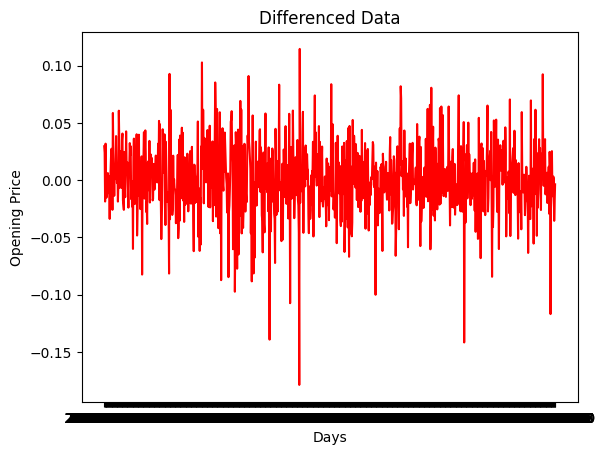

In [10]:
diff1 = df.loc[:,'Open'].diff(1)
nn = diff1.dropna() # - df.seasonalcomp[1:]
plt.plot(nn,'r')
plt.title('Differenced Data')
plt.xlabel('Days')
plt.ylabel('Opening Price')

from statsmodels.tsa.stattools import adfuller

# ADF test on difference data:
adf_result = adfuller(nn, regression='n', autolag='AIC')  # 'n' kullanarak
print("ADF test results:", adf_result)
print('Low p-value of ADF test ({}) shows that we will reject null hypothesis. \n Hence, the residual is close to stationary.'.format(adf_result[1]))
print('Data is not getting stationary by multiple differencings. So data is trend stationary.')


In [11]:
trainfrac = 0.75
df_train, df_test = train_test_split(df, train_size=trainfrac, shuffle=False, stratify=None)

# ARIMA

In [13]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA  # Updated import

# Assuming df_train is your training dataset and 'Open' is the target column
for p in range(0, 3):
    for d in range(0, 2):  # Usually 0 or 1 for differencing
        for q in range(0, 3):
            try:
                # Create ARIMA model
                df_arima = ARIMA(df_train['Open'].tolist(), order=(p, d, q))
                # Fit the model
                df_arima_fit = df_arima.fit(start_params=0.1 * np.ones(p + q + 1))
                print(f'ARIMA({p}, {d}, {q}) fitted successfully.')
                print(df_arima_fit.summary())
            except Exception as e:
                print(f'Error fitting ARIMA({p}, {d}, {q}): {e}')


Error fitting ARIMA(0, 0, 0): index 1 is out of bounds for axis 0 with size 1
Error fitting ARIMA(0, 0, 1): index 2 is out of bounds for axis 0 with size 2
Error fitting ARIMA(0, 0, 2): index 3 is out of bounds for axis 0 with size 3
ARIMA(0, 1, 0) fitted successfully.
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  741
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1503.870
Date:                Thu, 03 Oct 2024   AIC                          -3005.740
Time:                        14:57:10   BIC                          -3001.134
Sample:                             0   HQIC                         -3003.964
                                - 741                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

In [14]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA  # Ensure this import is correct
import pmdarima as pm

model = pm.auto_arima(df_train['Open'], seasonal=False, stepwise=True, suppress_warnings=True)
opt_arima = model.order  # This will give you (p, d, q)
print(f'Optimal ARIMA parameters: {opt_arima}')
# Assuming df_train is your training dataset and 'Open' is the target column
# And opt_arima is defined as (p, d, q)
df_arima = ARIMA(df_train['Open'].tolist(), order=(opt_arima[0], opt_arima[1], opt_arima[2]))
df_arima_fit = df_arima.fit(start_params=0.1 * np.ones(opt_arima[0] + opt_arima[2] + 1))

# Print the summary of the fitted model
print(df_arima_fit.summary())


Optimal ARIMA parameters: (0, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  741
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1503.870
Date:                Thu, 03 Oct 2024   AIC                          -3005.740
Time:                        14:57:21   BIC                          -3001.134
Sample:                             0   HQIC                         -3003.964
                                - 741                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0010   3.63e-05     27.714      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               164.63
Prob(Q):   

Hata: Uygun değerler yerleştirilemedi. Uzunluk uyuşmazlığı.


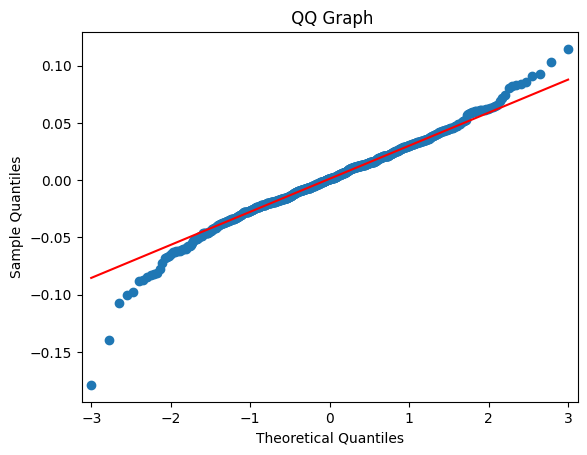

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

# Başlangıç indeksi
start_index = opt_arima[1]  # d değerini kullanarak başlangıç indeksi

# Eğer 'ARIMA' ve 'diff' sütunları yoksa ekle
if 'ARIMA' not in df_train.columns:
    df_train['ARIMA'] = np.nan
if 'diff' not in df_train.columns:
    df_train['diff'] = np.nan

# Fitted değerleri yerleştirme
num_fitted_values = len(df_arima_fit.fittedvalues)

# Yerleştirme işlemi
if start_index + num_fitted_values <= len(df_train):
    df_train.iloc[start_index:start_index + num_fitted_values, df_train.columns.get_loc('ARIMA')] = df_arima_fit.fittedvalues
    df_train.iloc[start_index:start_index + num_fitted_values, df_train.columns.get_loc('diff')] = df_arima_fit.fittedvalues + df_arima_fit.resid[:num_fitted_values]
else:
    print("Hata: Uygun değerler yerleştirilemedi. Uzunluk uyuşmazlığı.")

# Kalıntıların normal dağılım kontrolü için QQ grafiği
qqplot(data=df_arima_fit.resid, line='q')
plt.title(' QQ Graph')
plt.show()


<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
C:\Users\KaanGermiyan\AppData\Local\Temp\ipykernel_23872\1941362729.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
C:\Users\KaanGermiyan\AppData\Local\Temp\ipykernel_23872\1941362729.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(resid, fit=stats.norm)


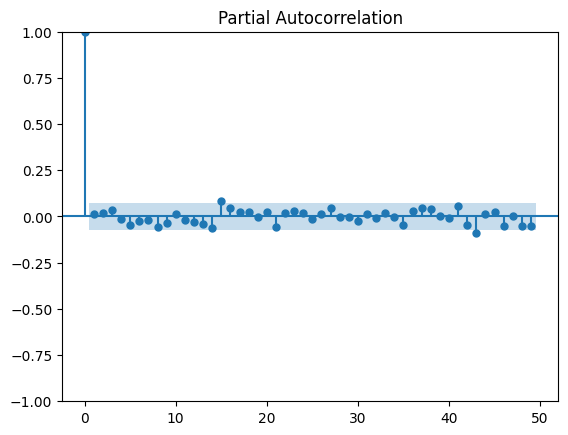

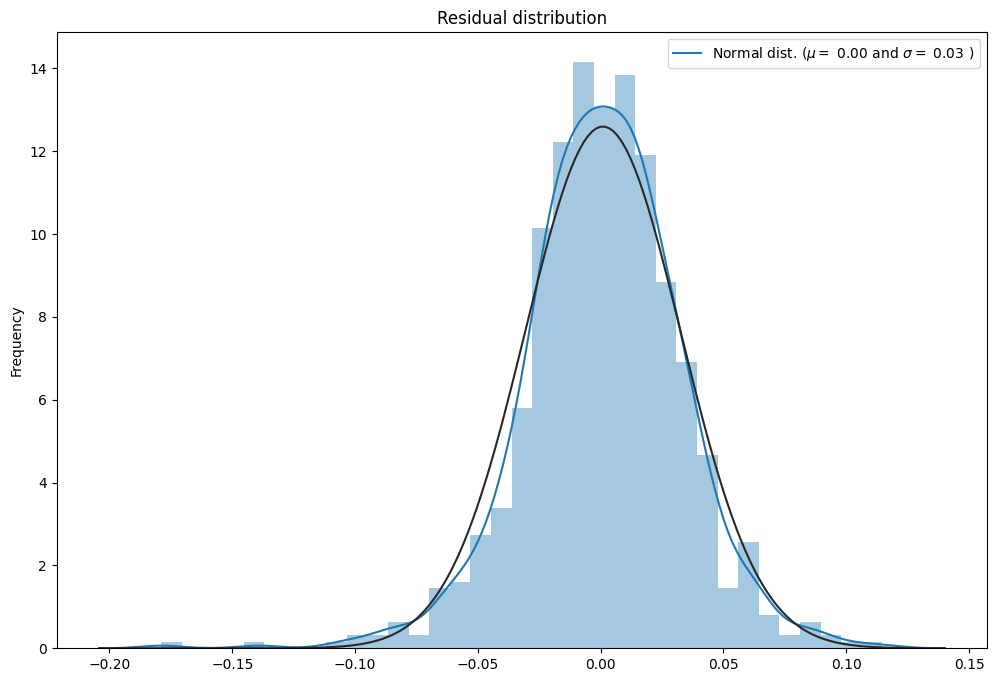

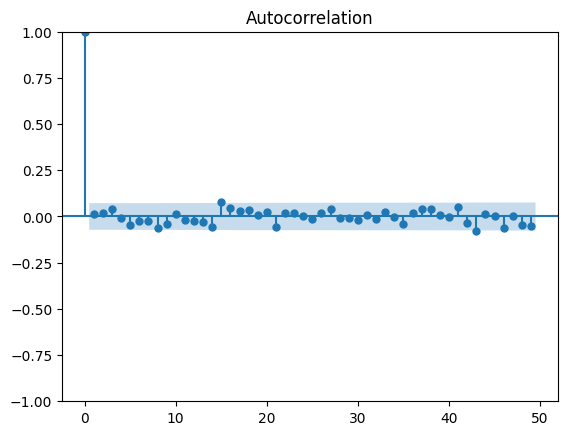

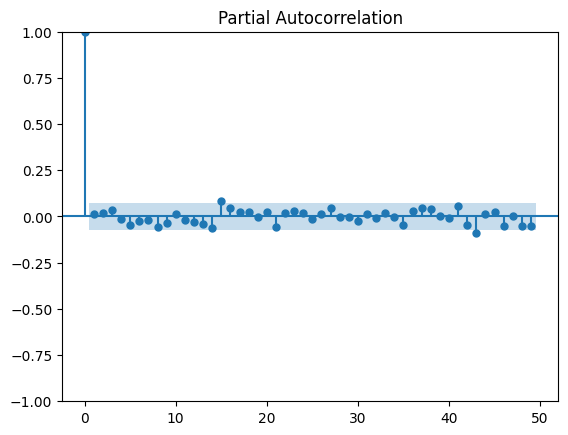

In [16]:
# Checking if the residuals are iid noise.
resid = df_arima_fit.resid
fig = plt.figure(figsize=(12,8))
sns.distplot(resid, fit=stats.norm)
(mu, sigma) = stats.norm.fit(resid)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')
tsaplots.plot_acf(resid, ax=None, lags=np.arange(50), use_vlines=True)
tsaplots.plot_pacf(resid, ax=None, lags=np.arange(50), use_vlines=True)

C:\Users\KaanGermiyan\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\KaanGermiyan\AppData\Local\Temp\ipykernel_23872\1309501204.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(df_test['Open'][i])
C:\Users\KaanGermiyan\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\KaanGermiyan\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: Con

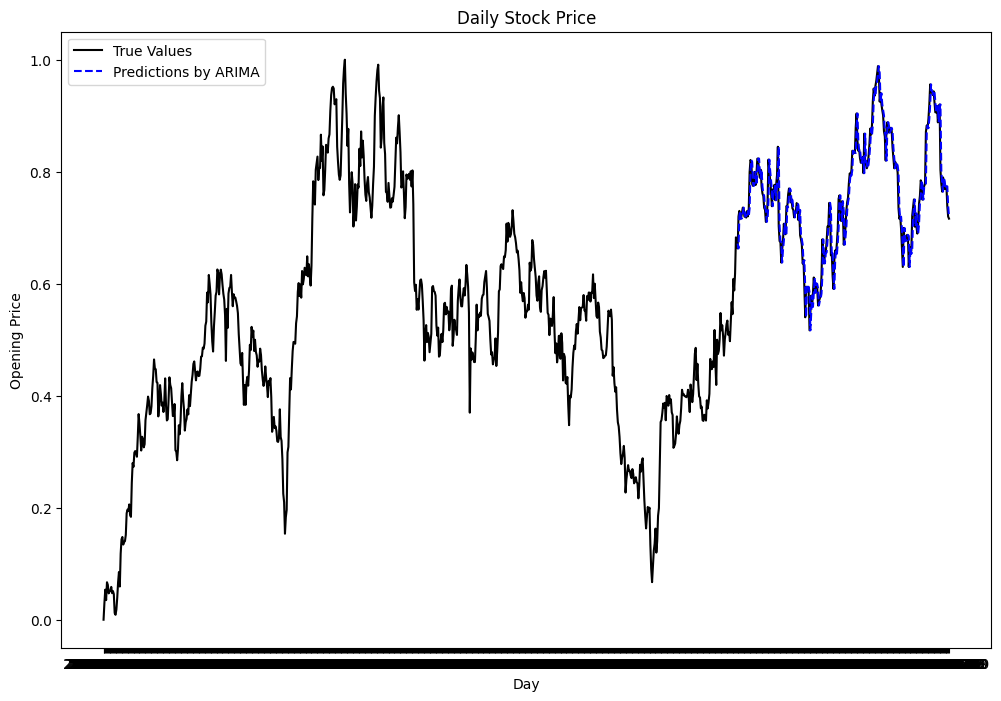

In [17]:
from statsmodels.tsa.arima.model import ARIMA

def sarima_forecast_recursive(history, config, n):
    model = ARIMA(history, order=config['order'])
    fittedmodel = model.fit(start_params=np.ones(n) * 0.1)
    forecast = fittedmodel.forecast(steps=1, alpha=0.05)
    return forecast


# config referes to sarima model that is the same for recursive forecasting.
config = {"order":[opt_arima[0],opt_arima[1],opt_arima[2]]}
history = df_train['Open'].tolist()
predictions = []
n = config['order'][0]+config['order'][2]+1

for i in range(len(df_test)):
    yhat = sarima_forecast_recursive(history, config, n)
    predictions.append(yhat[0])
    history.append(df_test['Open'][i])

df_forecasted_SARIMAX = pd.DataFrame(index=df.index[math.floor(len(df)*trainfrac):].tolist(),
                                     data={'forecast': predictions})
plt.figure(figsize=(12,8))
plt.plot(df.loc[:,'Open'], 'k', df_forecasted_SARIMAX, 'b--')
plt.xlabel('Day')
plt.ylabel('Opening Price')
plt.title('Daily Stock Price')
plt.legend(['True Values', 'Predictions by ARIMA'], loc='best')
plt.show()

In [18]:
rmse_arima = RMSE(df_test['Open'].tolist(), predictions)
mape_arima = MAPE(df_test['Open'].tolist(), predictions)
smape_arima = SMAPE(df_test['Open'].tolist(), predictions)
msle_arima = MSLE(df_test['Open'].tolist(), predictions)
# Metrics is a dictionary to save metrics results for different methods.
Metrics = {"RMSE_ARIMA": rmse_arima, "MAPE_ARIMA": mape_arima, "SMAPE_ARIMA": smape_arima,
          "MSLE_ARIMA": msle_arima}
Metrics

{'RMSE_ARIMA': 0.028955740461055517,
 'MAPE_ARIMA': 2.8671242454683026,
 'SMAPE_ARIMA': 2.859236160113778,
 'MSLE_ARIMA': 0.0002761744859311958}